In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Layer, Conv3D, BatchNormalization, Add, GlobalAveragePooling3D
from tensorflow.keras.utils import register_keras_serializable
import sys

In [ ]:
# Enabling GPU memory growth
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print("Failed to enable GPU memory growth:", e)

In [ ]:
# Loading train_data from the HDF5 file
train_rnet_path='/content/drive/MyDrive/train_temporal_data.h5'
val_rnet_path='/content/drive/MyDrive/validation_temporal_data.h5'
train_rnet_data = []
with h5py.File(train_rnet_path, 'r') as f:
    for video_name in f:
        video_group = f[video_name]
        frames = video_group['frames'][:]
        label = video_group['label'][()]
        train_rnet_data.append((frames, label))

# Loading val_data from the HDF5 file
val_rnet_data = []
with h5py.File(val_rnet_path, 'r') as f:
    for video_name in f:
        video_group = f[video_name]
        frames = video_group['frames'][:]
        label = video_group['label'][()]
        val_rnet_data.append((frames, label))

In [ ]:
# Creating a generator function for the dataset
def dataset_generator(data):
    for frames, label in data:
        yield frames, label

# Converting the lists to TensorFlow datasets using from_generator
train_rnet_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_generator(train_rnet_data),
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3)),  # frames: (num_frames, 224, 224, 3)
        tf.TensorSpec(shape=(), dtype=tf.float32)  # label: scalar
    )
)

val_rnet_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_generator(val_rnet_data),
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3)),  # frames: (num_frames, 224, 224, 3)
        tf.TensorSpec(shape=(), dtype=tf.float32)  # label: scalar
    )
)

In [ ]:
def check_min_max_frames(dataset, dataset_name):
    print(f"Checking min and max frame values for {dataset_name}...")
    min_value = float('inf')
    max_value = float('-inf')

    for frames, label in dataset:
        # Update global min and max
        batch_min = tf.reduce_min(frames).numpy()
        batch_max = tf.reduce_max(frames).numpy()
        min_value = min(min_value, batch_min)
        max_value = max(max_value, batch_max)

    print(f"Minimum frame value in {dataset_name}: {min_value}")
    print(f"Maximum frame value in {dataset_name}: {max_value}")
    print()

# Checking min and max values for train_dataset
check_min_max_frames(train_rnet_dataset, "train_rnet_dataset")

# Checking min and max values for val_dataset
check_min_max_frames(val_rnet_dataset, "test_rnet_dataset")

Checking min and max frame values for train_rnet_dataset...
Minimum frame value in train_rnet_dataset: 0.0
Maximum frame value in train_rnet_dataset: 1.0

Checking min and max frame values for test_rnet_dataset...
Minimum frame value in test_rnet_dataset: 0.0
Maximum frame value in test_rnet_dataset: 1.0



In [ ]:
# Counting the number of videos in each set
num_train_rnet_videos = len(train_rnet_data)
num_val_rnet_videos = len(val_rnet_data)

print(f"Number of videos in the training set: {num_train_rnet_videos}")
print(f"Number of videos in the val set: {num_val_rnet_videos}")

Number of videos in the training set: 320
Number of videos in the val set: 79


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),  # Random horizontal flip
    tf.keras.layers.RandomRotation(0.1),      # Random rotation (±10%)
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),  # Random translation (±10%)
    tf.keras.layers.RandomZoom(height_factor=0.1),  # Random zoom (±10%)
    tf.keras.layers.GaussianNoise(stddev=0.01),  # Add slight Gaussian noise
    tf.keras.layers.RandomContrast(factor=0.1),  # Slight contrast adjustment (±10%)
])

In [ ]:
def augment_data(frames, label):
    """
    Applies data augmentation to the frames.
    Args:
        frames: Tensor of shape (num_frames, 224, 224, 3)
        label: Tensor of shape ()
    Returns:
        augmented_frames: Tensor of shape (num_frames, 224, 224, 3)
        label: Tensor of shape ()
    """
    # Ensure the shape of frames is fully defined (no batch dimension)
    frames = tf.ensure_shape(frames, [None, 224, 224, 3])  # num_frames can be None

    # Debug: Print input frames min and max using tf.print
    #tf.print("Input frames min:", tf.reduce_min(frames))
    #tf.print("Input frames max:", tf.reduce_max(frames))

    # Apply augmentation to each frame in the sequence using tf.map_fn
    augmented_frames = tf.map_fn(
        lambda frame: data_augmentation(tf.expand_dims(frame, axis=0))[0],  # Add batch dimension, apply augmentation, and remove batch dimension
        frames,  # Input tensor
        fn_output_signature=tf.float32  # Output dtype and shape
    )

    # Debug: Print augmented frames min and max (before clipping) using tf.print
    #tf.print("Augmented frames min (before clipping):", tf.reduce_min(augmented_frames))
    #tf.print("Augmented frames max (before clipping):", tf.reduce_max(augmented_frames))

    # Clip pixel values to [0, 1] after augmentation
    augmented_frames = tf.clip_by_value(augmented_frames, 0.0, 1.0)

    # Debug: Print augmented frames min and max (after clipping) using tf.print
    #tf.print("Augmented frames min (after clipping):", tf.reduce_min(augmented_frames))
    #tf.print("Augmented frames max (after clipping):", tf.reduce_max(augmented_frames))

    return augmented_frames, label

# Applying augmentation to the training dataset
train_rnet_augmented_dataset = train_rnet_dataset.map(augment_data)

In [ ]:
from matplotlib import pyplot as plt

def visualize_augmented_data(dataset, num_samples=5):
    """
    Visualizes a few augmented frames from the dataset.
    Args:
        dataset: The augmented dataset (e.g., train_augmented_dataset).
        num_samples: Number of frames to visualize.
    """
    # Taking one batch from the dataset
    for frames, label in dataset.take(1):  # Take one batch (unbatched)
        print("Frames shape:", frames.shape)  # Debug: Check the shape of the frames
        print("Label value:", label.numpy())  # Debug: Check the value of the label

        # Iterating over the first few frames in the batch
        for i in range(min(num_samples, frames.shape[0])):  # Iterate over frames
            frame = frames[i]  # Extract the i-th frame

            print(f"Frame {i + 1} shape:", frame.shape)  # Debug: Check the shape of the individual frame
            print(f"Frame {i + 1} min value:", tf.reduce_min(frame).numpy())  # Debug: Check min pixel value
            print(f"Frame {i + 1} max value:", tf.reduce_max(frame).numpy())  # Debug: Check max pixel value
            print(f"Frame {i + 1} label:", label.numpy())  # Debug: Check the label value

            # Display the augmented frame
            plt.imshow(frame.numpy())  # Convert TensorFlow tensor to NumPy array for visualization
            plt.title(f"Label: {label.numpy()}")  # Use the scalar label
            plt.axis('off')  # Hide axes
            plt.show()

Frames shape: (38, 224, 224, 3)
Label value: 1.0
Frame 1 shape: (224, 224, 3)
Frame 1 min value: 0.0
Frame 1 max value: 0.8271209
Frame 1 label: 1.0


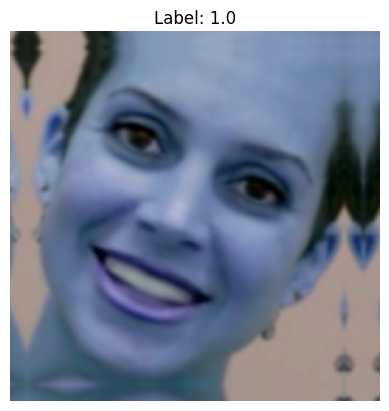

Frame 2 shape: (224, 224, 3)
Frame 2 min value: 0.0
Frame 2 max value: 0.81867826
Frame 2 label: 1.0


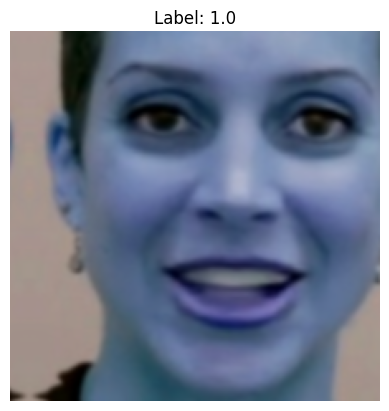

Frame 3 shape: (224, 224, 3)
Frame 3 min value: 0.0
Frame 3 max value: 0.81787294
Frame 3 label: 1.0


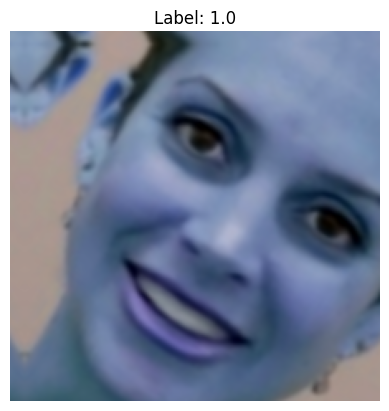

Frame 4 shape: (224, 224, 3)
Frame 4 min value: 0.0
Frame 4 max value: 0.84502786
Frame 4 label: 1.0


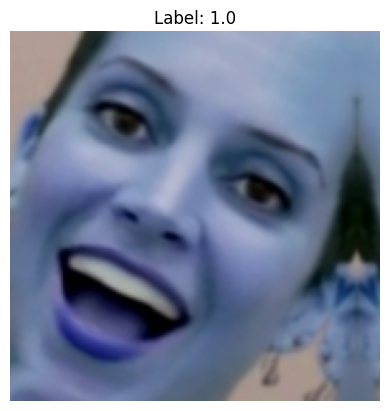

Frame 5 shape: (224, 224, 3)
Frame 5 min value: 0.0
Frame 5 max value: 0.841727
Frame 5 label: 1.0


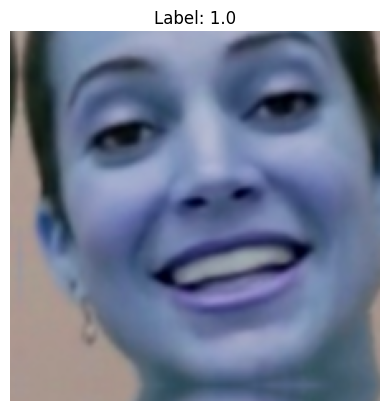

In [ ]:
# Visualizing augmented frames
visualize_augmented_data(train_rnet_augmented_dataset, num_samples=5)

In [ ]:
# Using padded_batch to handle varying frame lengths
batch_size = 4
padded_shapes = (
    [None, 224, 224, 3],  # Frames: (num_frames, 224, 224, 3) -> padded to max_frames in batch
    []                    # Label: scalar
)

# Creating the final data loaders
train_rnet_loader = train_rnet_augmented_dataset.padded_batch(batch_size, padded_shapes=padded_shapes).prefetch(tf.data.experimental.AUTOTUNE)
val_rnet_loader =val_rnet_dataset.padded_batch(batch_size, padded_shapes=padded_shapes).prefetch(tf.data.experimental.AUTOTUNE)

# Printing the sizes of the train and validation datasets
print(f"Number of videos in training set: {len(train_rnet_data)}")
print(f"Number of videos in validation set: {len(val_rnet_data)}")

Number of videos in training set: 320
Number of videos in validation set: 79


In [ ]:
# Calculating the number of validation samples
test_rnet_fraction = 0.01  # 1% of the training data
num_train_rnet_samples = len(train_rnet_data)  # Total number of training samples
num_test_rnet_samples = int(num_train_rnet_samples * test_rnet_fraction)  # Number of validation samples

In [ ]:
# Taking a small fraction of the augmented training data for validation
test_rnet_loader = train_rnet_loader.take(num_test_rnet_samples)

# Using the remaining data for training
train_rnet_loader_1 = train_rnet_loader.skip(num_test_rnet_samples)

In [ ]:
# Printing the sizes of the data loaders
print(f"Number of batches in train_loader (full): {len(list(train_rnet_loader))}")
print(f"Number of batches in val_loader: {len(list(val_rnet_loader))}")
print(f"Number of batches in train_loader_remaining: {len(list(train_rnet_loader_1))}")
print(f"Number of batches in test_loader: {len(list(test_rnet_loader))}")

Number of batches in train_loader (full): 80
Number of batches in val_loader: 20
Number of batches in train_loader_remaining: 77
Number of batches in test_loader: 3


In [ ]:
# Taking a sample batch from the train_loader
for batch in train_rnet_loader_1.take(1):
    frames, label = batch  # Only unpack frames and label
    print("Frames shape:", frames.shape)  # Should be (batch_size, num_frames, 224, 224, 3)
    print("Label shape:", label.shape)    # Should be (batch_size,)
    break

Frames shape: (4, 38, 224, 224, 3)
Label shape: (4,)


In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras import layers

# Building InceptionResNetV2 for spatial feature extraction
def build_inception_resnet_v2():
    base_model = InceptionResNetV2(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
    base_model.trainable = False  # Freeze the model
    # Unfreezing the top 20 layers
    for layer in base_model.layers[-20:]:
      layer.trainable = True
    return base_model

In [ ]:
# Defining the depthwise_separable_conv3d function
def depthwise_separable_conv3d(x, filters, kernel_size, strides=(1, 1, 1), padding='same'):
    # Depthwise Convolution
    depthwise_filters = x.shape[-1]  # Number of input channels
    x = Conv3D(
        depthwise_filters,  # Number of output channels = number of input channels
        kernel_size,
        strides=strides,
        padding=padding,
        groups=depthwise_filters,  # Groups = number of input channels (depthwise)
        kernel_regularizer=tf.keras.regularizers.l2(1e-4)  # L2 regularization
    )(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

    # Pointwise Convolution
    x = Conv3D(
        filters,  # Number of output filters
        (1, 1, 1),  # 1x1x1 kernel for pointwise convolution
        strides=(1, 1, 1),
        padding='same',
        kernel_regularizer=tf.keras.regularizers.l2(1e-4)  # L2 regularization
    )(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

    return x

In [ ]:
# Defining the custom SqueezeLayer
# Serializing custom Objects for future use
@register_keras_serializable()
class SqueezeLayer(Layer):
    def __init__(self, axis=None, **kwargs):
        super(SqueezeLayer, self).__init__(**kwargs)
        self.axis = axis  # Axis to squeeze (e.g., [2, 3])

    def call(self, inputs):
        return tf.squeeze(inputs, axis=self.axis)  #squeeze operation

    def get_config(self):
        config = super(SqueezeLayer, self).get_config()
        config.update({"axis": self.axis})  # Saving the axis in the config
        return config

# Defining the build_c3d_with_skip_connections function
def build_c3d_with_skip_connections():
    # Input shape: (timesteps, 5, 5, 1536)
    inputs = tf.keras.Input(shape=(None, 5, 5, 1536))

    # First Depthwise Separable Conv3D block
    x = depthwise_separable_conv3d(inputs, filters=64, kernel_size=(3, 3, 3))

    # Saving the output for skip connection
    skip1 = Conv3D(
        64,
        (1, 1, 1),
        strides=(1, 1, 1),
        padding='same',
        kernel_regularizer=tf.keras.regularizers.l2(1e-4)  # L2 regularization
    )(inputs)  # Adjust skip1 to match filters
    skip1 = BatchNormalization()(skip1)

    # Adding skip connection from the first block
    x = Add()([x, skip1])  # Skip connection

    # Second Depthwise Separable Conv3D block
    x = depthwise_separable_conv3d(x, filters=128, kernel_size=(3, 3, 3))


    skip2 = Conv3D(
        128,
        (1, 1, 1),
        strides=(1, 1, 1),
        padding='same',
        kernel_regularizer=tf.keras.regularizers.l2(1e-4)
    )(x)
    skip2 = BatchNormalization()(skip2)


    x = Add()([x, skip2])

    # Third Depthwise Separable Conv3D block
    x = depthwise_separable_conv3d(x, filters=256, kernel_size=(3, 3, 3))

    # Global Average Pooling to reduce dimensions (keep timesteps dimension)
    x = GlobalAveragePooling3D(keepdims=True)(x)  # Shape: (batch_size, timesteps, 1, 1, 256)

    # Custom SqueezeLayer
    x = SqueezeLayer(axis=[2, 3])(x)  # Squeeze dimensions 2 and 3

    # Creating the model
    model = tf.keras.Model(inputs, x)
    return model

In [ ]:
# Defining the custom StandardAttention layer
@register_keras_serializable()
class StandardAttention(Layer):
    def __init__(self, units, **kwargs):
        super(StandardAttention, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        # Creating trainable weights for the attention mechanism
        self.W = self.add_weight(
            name="W",
            shape=(input_shape[-1], self.units),  # (features, units)
            initializer="glorot_uniform",
            trainable=True,
        )
        self.V = self.add_weight(
            name="V",
            shape=(self.units, 1),  # (units, 1)
            initializer="glorot_uniform",
            trainable=True,
        )
        super(StandardAttention, self).build(input_shape)

    def call(self, features):
        # Computing attention scores
        attention_scores = tf.keras.activations.tanh(tf.matmul(features, self.W))  # Shape: (batch_size, timesteps, units)

        # Computing attention weights using softmax over timesteps
        attention_weights = tf.keras.activations.sigmoid(tf.matmul(attention_scores, self.V))  # Shape: (batch_size, timesteps, 1)

        # Applying attention weights to features
        context_vector = attention_weights * features  # Shape: (batch_size, timesteps, features)

        # Suming over the timesteps dimension
        context_vector = tf.reduce_sum(context_vector, axis=1)  # Shape: (batch_size, features)

        return context_vector  # Shape: (batch_size, features)

    def get_config(self):
        config = super(StandardAttention, self).get_config()
        config.update({"units": self.units})  # Saving the units in the config
        return config

In [ ]:
# Building the temporal model
def build_temporal_model_with_attention_and_skip():

    input_shape = (None, 224, 224, 3)  # (timesteps, height, width, channels)
    inputs = tf.keras.Input(shape=input_shape)

    # Spatial feature extraction for each frame using InceptionResNetV2
    spatial_model = build_inception_resnet_v2()
    spatial_features = tf.keras.layers.TimeDistributed(spatial_model)(inputs)

    # Temporal feature extraction using C3D with skip connections
    c3d_model = build_c3d_with_skip_connections()
    temporal_features = c3d_model(spatial_features)

    # Adding Standard Attention
    attention_layer = StandardAttention(units=256)
    context_vector = attention_layer(temporal_features)  # Shape: (batch_size, features)

    # Debug statement for the shape of the context vector before passing it to the Dense layer
    print("Context vector shape before Dense:", context_vector.shape)

    # Adding a classifier on top
    x = tf.keras.layers.Dense(
        128,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(1e-4)
    )(context_vector)  # Shape: (batch_size, 128)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(
        1,
        activation='sigmoid',
        kernel_regularizer=tf.keras.regularizers.l2(1e-4)
    )(x)  # Shape: (batch_size, 1)

    return tf.keras.Model(inputs, outputs)

In [ ]:
# Building the temporal model with attention and skip connections
temporal_model_with_attention_and_skip = build_temporal_model_with_attention_and_skip()

# Model summary
temporal_model_with_attention_and_skip.summary()

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
Context vector shape before Dense: (None, 256)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, None, 224, 224, 3)   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, None, 5, 5, 1536)    │      54,336,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_1 (Functional)            │ (None, 1, 256)              │         312,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ standard_attention                   │ (None, 256)                 │          65,792 │
│ (StandardAttention)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,748,001 (208.85 MB)

 Trainable params: 5,637,505 (21.51 MB)

 Non-trainable params: 49,110,496 (187.34 MB)

In [ ]:
from tensorflow.keras.metrics import Precision, Recall
# Defining the metrics
tp = tf.keras.metrics.TruePositives(thresholds=None, name='true_positives')
tn = tf.keras.metrics.TrueNegatives(thresholds=None, name='true_negatives')
fp = tf.keras.metrics.FalsePositives(thresholds=None, name='false_positives')
fn = tf.keras.metrics.FalseNegatives(thresholds=None, name='false_negatives')
precision = tf.keras.metrics.Precision(name='precision')
recall = tf.keras.metrics.Recall(name='recall')


# Registering the custom f1_score function
# Defining precision and recall metrics outside the function
precision_metric = Precision()
recall_metric = Recall()

@tf.keras.utils.register_keras_serializable()
def f1_score(y_true, y_pred):
    precision_value = precision_metric(y_true, y_pred)
    recall_value = recall_metric(y_true, y_pred)
    return 2 * ((precision_value * recall_value) / (precision_value + recall_value + tf.keras.backend.epsilon()))


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# AdamW optimizer with a fixed initial learning rate
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=1e-4,  # Fixed initial learning rate
    beta_1=0.9,          # Exponential decay rate for 1st moment (mean)
    beta_2=0.999,        # Exponential decay rate for 2nd moment (variance)
    epsilon=1e-07,       # Small constant for numerical stability
    weight_decay=1e-5,   # Weight decay for regularization
    amsgrad=False,       # Don't use AMSGrad variant
    clipnorm=1.0
)

# ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.1,          # Reduce learning rate by a factor of 0.1
    patience=3,          # Wait for 3 epochs without improvement
    min_lr=1e-6,         # Minimum learning rate
    verbose=1            # Print a message when learning rate is reduced
)

In [ ]:
# Compiling the model with all metrics
temporal_model_with_attention_and_skip.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',  # Loss function
    metrics=[
        'accuracy',  # Standard accuracy
        #tp, tn, fp, fn,  # True/False Positives/Negatives
        precision, recall,  # Precision and Recall
        f1_score  # Custom F1-score
    ]
)

In [ ]:
# Steps for training and validation
steps_per_epoch = 19
validation_steps = 5

In [ ]:
# Applying .repeat() to Repeat datasets indefinitely
train_rnet_loader_1 = train_rnet_loader_1.repeat()
val_rnet_loader = val_rnet_loader.repeat()

In [ ]:
# Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Stop after 5 epochs without improvement
    restore_best_weights=True,  # Restore the best model weights
    mode='min'           # Minimize validation loss
)

# Model Checkpoint
model_checkpoint_loss = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',  # Save the best model here
    monitor='val_loss',        # Monitor validation loss
    save_best_only=True,       # Save only the best model
    mode='min',                # Minimize validation loss
    verbose=1                  # Print a message when saving the model
)

In [ ]:
# Adding these callbacks to fit() method
history = temporal_model_with_attention_and_skip.fit(
    train_rnet_loader_1,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_rnet_loader,
    validation_steps=validation_steps,
    epochs=20,
    callbacks=[early_stopping, model_checkpoint_loss, reduce_lr]
)

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.5084 - f1_score: 0.6138 - loss: 0.7965 - precision: 0.4615 - recall: 0.7751 
Epoch 1: val_loss improved from inf to 0.77361, saving model to best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 750s 37s/step - accuracy: 0.5093 - f1_score: 0.6118 - loss: 0.7956 - precision: 0.4620 - recall: 0.7742 - val_accuracy: 0.5500 - val_f1_score: 0.5550 - val_loss: 0.7736 - val_precision: 1.0000 - val_recall: 0.1000 - learning_rate: 1.0000e-04
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - accuracy: 0.6038 - f1_score: 0.5695 - loss: 0.7506 - precision: 0.6331 - recall: 0.7780 
Epoch 2: val_loss improved from 0.77361 to 0.77325, saving model to best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 646s 34s/step - accuracy: 0.6039 - f1_score: 0.5706 - loss: 0.7510 - precision: 0.6327 - recall: 0.7789 - val_accuracy: 0.6500 - val_f1_score: 0.6249 - val_loss: 0.7732 - val_precision: 0.5882 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - accuracy: 0.6244 - f1_score: 0.6404 - loss: 0.7520 - precision: 0.6315 - recall: 0.7434 
Epoch 3: val_loss improved from 0.77325 to 0.77299, saving model to best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 641s 34s/step - accuracy: 0.6175 - f1_score: 0.6401 - loss: 0.7534 - precision: 0.6234 - recall: 0.7396 - val_accuracy: 0.6000 - val_f1_score: 0.6143 - val_loss: 0.7730 - val_precision: 0.5556 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - accuracy: 0.6032 - f1_score: 0.6227 - loss: 0.7266 - precision: 0.5732 - recall: 0.8013 
Epoch 4: val_loss improved from 0.77299 to 0.77212, saving model to best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 641s 34s/step - accuracy: 0.6006 - f1_score: 0.6227 - loss: 0.7278 - precision: 0.5733 - recall: 0.7942 - val_accuracy: 0.6500 - val_f1_score: 0.6172 - val_loss: 0.7721 - val_precision: 1.0000 - val_recall: 0.3000 - learning_rate: 1.0000e-04
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - accuracy: 0.7288 - f1_score: 0.6223 - loss: 0.7044 - precision: 0.6626 - recall: 0.8912 
Epoch 5: val_loss improved from 0.77212 to 0.77096, saving model to best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 646s 34s/step - accuracy: 0.7233 - f1_score: 0.6223 - loss: 0.7058 - precision: 0.6572 - recall: 0.8834 - val_accuracy: 0.7500 - val_f1_score: 0.6178 - val_loss: 0.7710 - val_precision: 1.0000 - val_recall: 0.5000 - learning_rate: 1.0000e-04
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - accuracy: 0.7199 - f1_score: 0.6246 - loss: 0.6943 - precision: 0.7569 - recall: 0.7483 
Epoch 6: val_loss improved from 0.77096 to 0.76745, saving model to best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 645s 33s/step - accuracy: 0.7168 - f1_score: 0.6248 - loss: 0.6953 - precision: 0.7551 - recall: 0.7453 - val_accuracy: 0.8000 - val_f1_score: 0.6331 - val_loss: 0.7674 - val_precision: 0.7143 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.7239 - f1_score: 0.6426 - loss: 0.6292 - precision: 0.6644 - recall: 0.8957 
Epoch 7: val_loss did not improve from 0.76745
19/19 ━━━━━━━━━━━━━━━━━━━━ 615s 32s/step - accuracy: 0.7246 - f1_score: 0.6427 - loss: 0.6302 - precision: 0.6642 - recall: 0.8952 - val_accuracy: 0.5000 - val_f1_score: 0.6500 - val_loss: 0.7714 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - accuracy: 0.7346 - f1_score: 0.6548 - loss: 0.5582 - precision: 0.6939 - recall: 0.8409 
Epoch 8: val_loss improved from 0.76745 to 0.75134, saving model to best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 612s 32s/step - accuracy: 0.7347 - f1_score: 0.6549 - loss: 0.5589 - precision: 0.6964 - recall: 0.8379 - val_accuracy: 0.7000 - val_f1_score: 0.6628 - val_loss: 0.7513 - val_precision: 0.6667 - val_recall: 0.8000 - learning_rate: 1.0000e-04
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - accuracy: 0.8063 - f1_score: 0.6692 - loss: 0.5342 - precision: 0.7293 - recall: 0.9505 
Epoch 9: val_loss improved from 0.75134 to 0.73911, saving model to best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 667s 35s/step - accuracy: 0.8035 - f1_score: 0.6693 - loss: 0.5377 - precision: 0.7266 - recall: 0.9456 - val_accuracy: 0.8500 - val_f1_score: 0.6728 - val_loss: 0.7391 - val_precision: 0.8889 - val_recall: 0.8000 - learning_rate: 1.0000e-04
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - accuracy: 0.7502 - f1_score: 0.6777 - loss: 0.5995 - precision: 0.7766 - recall: 0.7712 
Epoch 10: val_loss improved from 0.73911 to 0.70822, saving model to best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 646s 35s/step - accuracy: 0.7495 - f1_score: 0.6778 - loss: 0.6020 - precision: 0.7761 - recall: 0.7710 - val_accuracy: 0.9000 - val_f1_score: 0.6849 - val_loss: 0.7082 - val_precision: 0.9000 - val_recall: 0.9000 - learning_rate: 1.0000e-04
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - accuracy: 0.7404 - f1_score: 0.6887 - loss: 0.6036 - precision: 0.7954 - recall: 0.7681 
Epoch 11: val_loss did not improve from 0.70822
19/19 ━━━━━━━━━━━━━━━━━━━━ 619s 33s/step - accuracy: 0.7435 - f1_score: 0.6888 - loss: 0.5995 - precision: 0.7943 - recall: 0.7733 - val_accuracy: 0.5500 - val_f1_score: 0.6955 - val_loss: 0.7349 - val_precision: 0.5294 - val_recall: 0.9000 - learning_rate: 1.0000e-04
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.7915 - f1_score: 0.6970 - loss: 0.5845 - precision: 0.6556 - recall: 0.8832 
Epoch 12: val_loss improved from 0.70822 to 0.69609, saving model to best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 609s 33s/step - accuracy: 0.7920 - f1_score: 0.6971 - loss: 0.5817 - precision: 0.6612 - recall: 0.8825 - val_accuracy: 0.7000 - val_f1_score: 0.7030 - val_loss: 0.6961 - val_precision: 0.6667 - val_recall: 0.8000 - learning_rate: 1.0000e-04
Epoch 13/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - accuracy: 0.8937 - f1_score: 0.7078 - loss: 0.4154 - precision: 0.8455 - recall: 0.9702 
Epoch 13: val_loss did not improve from 0.69609
19/19 ━━━━━━━━━━━━━━━━━━━━ 648s 34s/step - accuracy: 0.8892 - f1_score: 0.7079 - loss: 0.4210 - precision: 0.8393 - recall: 0.9673 - val_accuracy: 0.6500 - val_f1_score: 0.7093 - val_loss: 0.7006 - val_precision: 0.5882 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 14/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - accuracy: 0.8502 - f1_score: 0.7130 - loss: 0.5171 - precision: 0.9369 - recall: 0.8044 
Epoch 14: val_loss improved from 0.69609 to 0.60322, saving model to best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 642s 34s/step - accuracy: 0.8465 - f1_score: 0.7131 - loss: 0.5214 - precision: 0.9333 - recall: 0.8006 - val_accuracy: 0.8500 - val_f1_score: 0.7150 - val_loss: 0.6032 - val_precision: 0.8889 - val_recall: 0.8000 - learning_rate: 1.0000e-04
Epoch 15/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - accuracy: 0.9140 - f1_score: 0.7196 - loss: 0.4213 - precision: 0.9231 - recall: 0.9262 
Epoch 15: val_loss did not improve from 0.60322
19/19 ━━━━━━━━━━━━━━━━━━━━ 634s 34s/step - accuracy: 0.9143 - f1_score: 0.7197 - loss: 0.4200 - precision: 0.9221 - recall: 0.9273 - val_accuracy: 0.7500 - val_f1_score: 0.7263 - val_loss: 0.6478 - val_precision: 0.7273 - val_recall: 0.8000 - learning_rate: 1.0000e-04
Epoch 16/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - accuracy: 0.8721 - f1_score: 0.7289 - loss: 0.4329 - precision: 0.7859 - recall: 0.9667 
Epoch 16: val_loss improved from 0.60322 to 0.54704, saving model to best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 588s 32s/step - accuracy: 0.8733 - f1_score: 0.7290 - loss: 0.4321 - precision: 0.7904 - recall: 0.9644 - val_accuracy: 0.8500 - val_f1_score: 0.7356 - val_loss: 0.5470 - val_precision: 0.8889 - val_recall: 0.8000 - learning_rate: 1.0000e-04
Epoch 17/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - accuracy: 0.9302 - f1_score: 0.7394 - loss: 0.3373 - precision: 0.8875 - recall: 0.9922 
Epoch 17: val_loss did not improve from 0.54704
19/19 ━━━━━━━━━━━━━━━━━━━━ 637s 34s/step - accuracy: 0.9271 - f1_score: 0.7395 - loss: 0.3424 - precision: 0.8829 - recall: 0.9912 - val_accuracy: 0.8000 - val_f1_score: 0.7427 - val_loss: 0.5477 - val_precision: 0.8000 - val_recall: 0.8000 - learning_rate: 1.0000e-04
Epoch 18/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.7448 - f1_score: 0.7436 - loss: 0.6095 - precision: 0.7143 - recall: 0.7421 
Epoch 18: val_loss improved from 0.54704 to 0.47633, saving model to best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 624s 33s/step - accuracy: 0.7450 - f1_score: 0.7436 - loss: 0.6092 - precision: 0.7183 - recall: 0.7419 - val_accuracy: 0.9000 - val_f1_score: 0.7450 - val_loss: 0.4763 - val_precision: 1.0000 - val_recall: 0.8000 - learning_rate: 1.0000e-04
Epoch 19/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.8931 - f1_score: 0.7478 - loss: 0.3664 - precision: 0.9053 - recall: 0.9034 
Epoch 19: val_loss improved from 0.47633 to 0.45685, saving model to best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 609s 32s/step - accuracy: 0.8918 - f1_score: 0.7478 - loss: 0.3685 - precision: 0.9019 - recall: 0.9043 - val_accuracy: 0.8500 - val_f1_score: 0.7514 - val_loss: 0.4569 - val_precision: 0.8889 - val_recall: 0.8000 - learning_rate: 1.0000e-04
Epoch 20/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - accuracy: 0.9535 - f1_score: 0.7540 - loss: 0.3321 - precision: 0.9142 - recall: 0.9855 
Epoch 20: val_loss did not improve from 0.45685
19/19 ━━━━━━━━━━━━━━━━━━━━ 560s 30s/step - accuracy: 0.9539 - f1_score: 0.7541 - loss: 0.3324 - precision: 0.9159 - recall: 0.9849 - val_accuracy: 0.8500 - val_f1_score: 0.7603 - val_loss: 0.4587 - val_precision: 0.8889 - val_recall: 0.8000 - learning_rate: 1.0000e-04


In [ ]:
# Save the model in Keras format
save_temporal_path = 'temporal_model_serialize_8.keras'
temporal_model_with_attention_and_skip.save(save_temporal_path)
print(f"Model saved in .keras format at: {save_temporal_path}")

Model saved in .keras format at: temporal_model_serialize_8.keras


In [ ]:
# Load the model with custom objects
loaded_model = tf.keras.models.load_model(
    save_temporal_path,
    custom_objects={
        'f1_score': f1_score,
        'StandardAttention': StandardAttention,
        'SqueezeLayer': SqueezeLayer  # Add the custom SqueezeLayer
    }
)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 52 variables whereas the saved optimizer has 102 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
test_rnet_loader=test_rnet_loader.repeat()

In [ ]:
test_loss, test_accuracy, test_f1_score, test_precision, test_recall = loaded_model.evaluate(test_rnet_loader, steps=20)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test F1 Score: {test_f1_score}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 335s 15s/step - accuracy: 0.8312 - f1_score: 0.7626 - loss: 0.4991 - precision: 0.7749 - recall: 1.0000
Test Loss: 0.4988959729671478
Test Accuracy: 0.8374999761581421
Test F1 Score: 0.7833333611488342
Test Precision: 1.0
Test Recall: 0.7639111280441284
